# Numerical Integration of a Toda Lattice

In [1]:
%matplotlib notebook
from matplotlib.pyplot import *
from rk4 import *
import numpy as np

## Physical Model

In short, the Toda Lattice equation is a N-oscillator chain nonlinear chain whose dynamics is described by
$$m\ddot{x}=\left\{ \exp\left[-v\left(x_{i-1}-x_{i}\right)\right]-\exp\left[-v\left(x_{i}-x_{i+1}\right)\right]\right\}
$$.

In the small amplitude regime, i.e. $x_i-x_{i+1}\approx \Delta + \delta_i$, it can be shown that the linear oscillator chain is recovered as 
$$m\ddot{x}=\left\{ \exp\left[-k\left(x_{i-1}-x_{i}\right)\right]-\exp\left[-k\left(x_{i}-x_{i+1}\right)\right]\right\}
$$

In [2]:
####Function to be integrated####
#################################
def todachain(v,n_osc,tinit,tstop,dt,initial_condition):
    
    def F(t,y):
        Fi=np.zeros(n_osc*2)
        for i in range(0,n_osc*2,2):
            Fi[i]=y[i+1]
            
            if i==n_osc*2-2:
                Fi[i+1]=(-np.exp(-v*(y[0]-y[i]))+np.exp(-v*(y[i]-y[i-2])))
            else:
                Fi[i+1]=(-np.exp(-v*(y[i+2]-y[i]))+np.exp(-v*(y[i]-y[i-2])))
             
        return Fi
            
    T,Y=integrate(F,0,initial_condition,tstop,dt)
    positions=np.zeros((len(T),n_osc))
    for i in range(0,len(T)):
        for j in range(0,n_osc):
            positions[i,j]=Y[i,2*j]
    return T,Y,positions

## Simulating a Toda Lattice

<IPython.core.display.Javascript object>


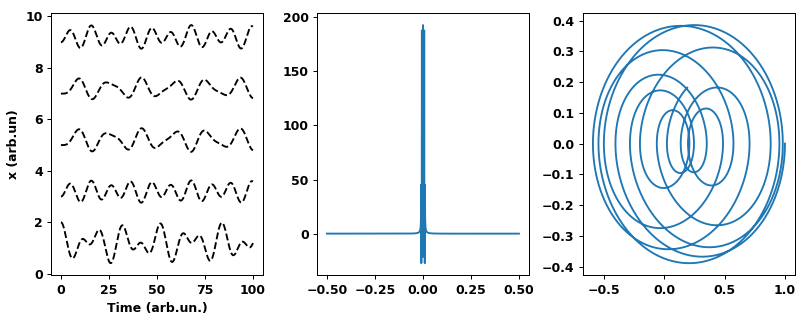

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


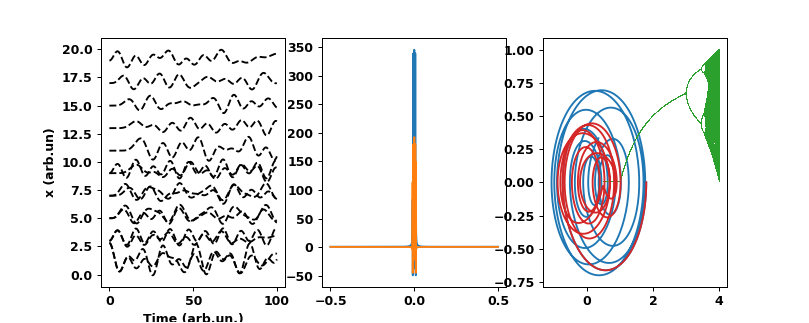

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [15]:

####
n_oscillators=5

#encoding amplitude
A = 1.0

#initial distance between consecutive oscillators
delta= 2

#integration parameters
tinit=0
tstop=100
dt=0.1

#nonlinearity strength
v=0.1
features=0
def encoding(n_osc,features,A,delta):    
    y=np.zeros(n_osc*2)
    for i in range(0,n_osc*2,2):
        if i == 0:
            y[0] = A
        else:
            y[i] = 0
    return y

####example results
fig, ax = subplots(1,3,figsize=[10,4])

initial_condition = encoding(n_oscillators,features, A, delta)
T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
for j in range(0,n_oscillators):
    ax[0].plot(T,positions[:,j]+(j*delta+delta/2),'--',color='k')
ax[0].set_xlabel('Time (arb.un.)')
ax[0].set_ylabel('x (arb.un)')

ax[1].plot(fft.fftshift(fft.fftfreq(len(positions[:,0]))),
           fft.fftshift(fft.fft(positions[:,0])))

ax[2].plot(Y[:,0],Y[:,1])

tight_layout()

fig, ax = subplots(1,3,figsize=[10,4])

A = 1.8
v=0.1
initial_condition = encoding(n_oscillators,features, A, delta)
T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
for j in range(0,n_oscillators):
    ax[0].plot(T,positions[:,j]+(j*delta+delta/2),'--',color='k')
ax[0].set_xlabel('Time (arb.un.)')
ax[0].set_ylabel('x (arb.un)')
ax[1].plot(fft.fftshift(fft.fftfreq(len(positions[:,0]))),
           fft.fftshift(fft.fft(positions[:,0])))

ax[2].plot(Y[:,0],Y[:,1])

<IPython.core.display.Javascript object>


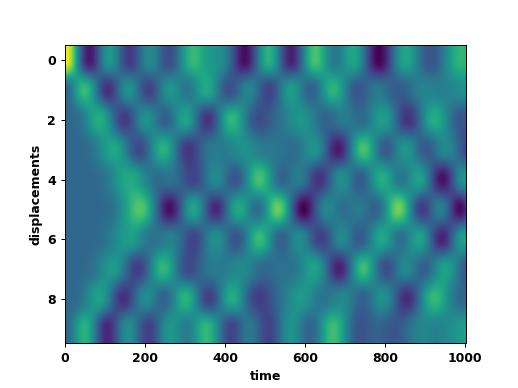

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  .format(nperseg, input_length))


<IPython.core.display.Javascript object>


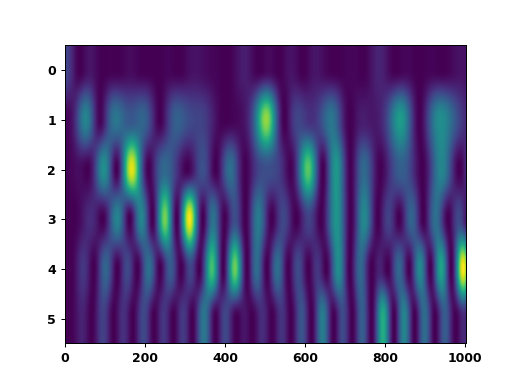

In [4]:
from scipy import signal
subplots()
imshow(np.transpose(Y[:,::2]),aspect='auto')
xlabel('time')
ylabel('displacements')

f,t, spec = signal.spectrogram(Y[:,::2], fs=1.0, window=('tukey', 0.25), 
                nperseg=None, noverlap=None, nfft=None, detrend='constant', 
                        return_onesided=True, scaling='density', axis=- 1, mode='psd')

subplots()
imshow(np.transpose(spec[:,:,0]),aspect='auto')

## Building a "Physical" Extreme Learning Machine

An Extreme Learning Machine leverages on the projection of each element I of the input space $$X^{(I)} = \left(\begin{array}{c}
x^{(I)}_{1}\\
...\\
x^{(I)}_{N_{features}}
\end{array}\right)$$ onto an high-dimensional output space 
$$
\boldsymbol{Y}\left(\boldsymbol{X}^{(I)}\right)=\left(\begin{array}{c}
G_{1}\left(w_{i}x_{i}^{(I)}+b_{i}\right)\\
G_{2}\left(w_{i}x_{i}^{(I)}+b_{i}\right)\\
...\\
G_{N_{c}}\left(w_{i}x_{i}^{(I)}+b_{i}\right)
\end{array}\right)
$$
with G the activiation function, w the weights and b the bias. 

In our physical implementation we will encode each feature in the initial displacement of the oscillator N and obtain the output information Y at the end of the simulation, defined by the $$t_{stop}$$.

In [5]:
def encoding(n_osc,features,A):
    
    y=np.zeros(n_osc*2)
    for i in range(0,n_osc*2,2):
        if i < len(features)*2:
            y[i]=A*features[int(i%2)]
        else:
            y[i]=0

    return y

####example results


A = 1.0
v= 0.5


#integration parameters
tinit=0
tstop=50
dt=0.1


npoints=64
x_train = [i for i in range(0,npoints,2)]
x_test = [i+1 for i in range(0,npoints,2)]


output_train_store=[]
for i in range(0,len(x_train)):
    print(str(i),end='\n')
    features = [x_train[i]/npoints+0.5]
    initial_condition = encoding(n_oscillators,features, A)
    T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
    output_train_store.append(positions[-1,:])
    
output_test_store=[]
for i in range(0,len(x_test)):
    print(str(i),end='\n')
    features = [x_test[i]/npoints+0.5]
    initial_condition = encoding(n_oscillators,features, A)
    T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
    output_test_store.append(positions[-1,:])
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


## Training 

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: scipy.sinc is deprecated and will be removed in SciPy 2.0.0, use numpy.sinc instead
  """
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.dot is deprecated and will be removed in SciPy 2.0.0, use numpy.dot instead
  


<IPython.core.display.Javascript object>


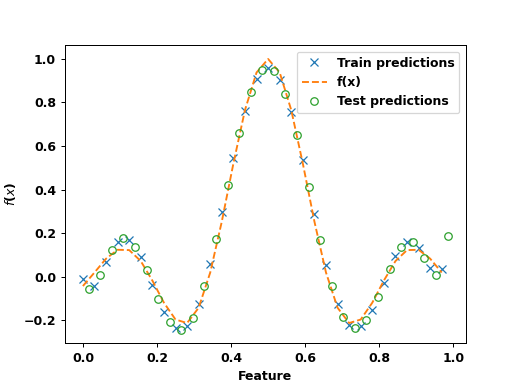

In [6]:
T_store=[]

#construct the function to train a regression
for number_x in range(0,npoints,2):
    T_store.append(sinc(pi*(number_x/float(npoints/2)-1)))

pseudo_inv=np.linalg.pinv(output_train_store)
W_out=dot(pseudo_inv,T_store)
train_data=np.dot(output_train_store, W_out)
test_data=np.dot(output_test_store, W_out)

subplots()
plot(np.array(x_train)/npoints,train_data,'x',label='Train predictions')
plot(np.array(x_train)/npoints,T_store,'--',label='f(x)')
plot(np.array(x_test)/npoints,test_data,'o',fillstyle='none',label='Test predictions')
xlabel('Feature')
ylabel('$f(x)$')
legend()

## Spiral dataset Classification

<IPython.core.display.Javascript object>


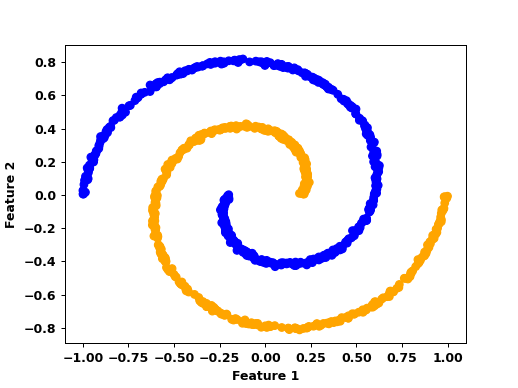

Text(0, 0.5, 'Feature 2')

In [7]:
import numpy as np

N = 500

def spiral(N):
    
    theta = np.random.rand(N)*2*np.pi 
    
    r_a = 2*theta + np.pi
    r_b = -2*theta - np.pi
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    x_a = data_a + 0.1*np.random.randn(N,2)
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    x_b = data_b + 0.1*np.random.randn(N,2)

    res_a = np.append(x_a/np.max(np.abs(x_a)), np.zeros((N,1)), axis=1)
    res_b = np.append(x_b/np.max(np.abs(x_b)), np.ones((N,1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)
    return res

res = spiral(N)
subplots()
def get_color(ss):
    colors=[]
    for i in range(0,len(ss)):
        
        if ss[i]==1:
            colors.append('b')
        else:
            colors.append('orange')
    return colors

scatter(res[:,0],res[:,1], color=get_color(res[:,2]))
xlabel('Feature 1')
ylabel('Feature 2')

In [8]:
A = 3.0
v= 0.2

n_oscillators = 20

def encoding(n_osc,features,A):
    
    y=np.zeros(n_osc*2)
    y[0] = A*features[0]
    y[4] = A*features[1]
#     for i in range(0,n_osc*2,2):
#         if i < len(features)*2:
#             y[i]=A*features[int(i//2)]
#         else:
#             y[i]=0

    return y


#integration parameters
tinit=0
tstop=100
dt=0.1

npoints=500
x_train = [res[i,:2] for i in range(0,npoints,2)]
train_labels = [res[i,2] for i in range(0,npoints,2)]
x_test = [res[i+1,:2] for i in range(0,npoints,2)]
test_labels = [res[i+1,2] for i in range(0,npoints,2)]


output_train_store=[]
for i in range(0,len(x_train)):
    print(str(i),end='\r')
    features = x_train[i]
    initial_condition = encoding(n_oscillators,features, A)
    T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
    output_train_store.append(positions[-1,:])
    
output_test_store=[]
for i in range(0,len(x_test)):
    print(str(i),end='\r')
    features = x_test[i]
    initial_condition = encoding(n_oscillators,features, A)
    T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
    output_test_store.append(positions[-1,:])

<IPython.core.display.Javascript object>


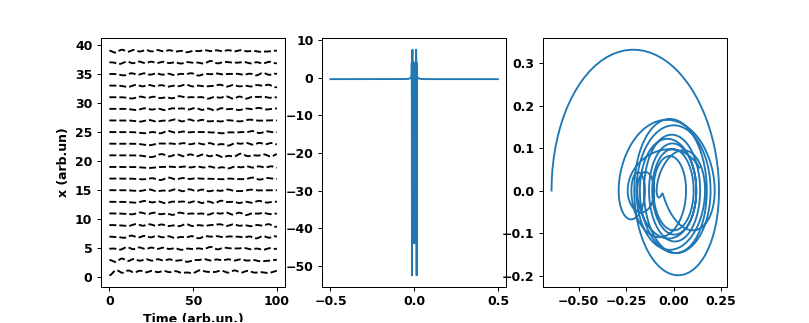

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [9]:
fig, ax = subplots(1,3,figsize=[10,4])
for j in range(0,n_oscillators):
    ax[0].plot(T,positions[:,j]+(j*delta+delta/2),'--',color='k')
ax[0].set_xlabel('Time (arb.un.)')
ax[0].set_ylabel('x (arb.un)')

ax[1].plot(fft.fftshift(fft.fftfreq(len(positions[:,0]))),
           fft.fftshift(fft.fft(positions[:,0])))

ax[2].plot(Y[:,0],Y[:,1])

In [10]:
output_matrix = np.array([np.array(output_train_store[i]) for i in range(0,len(output_train_store))])
np.linalg.matrix_rank(output_matrix)

20

# Training the model

Train -  0.984 Test -  0.988


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<IPython.core.display.Javascript object>


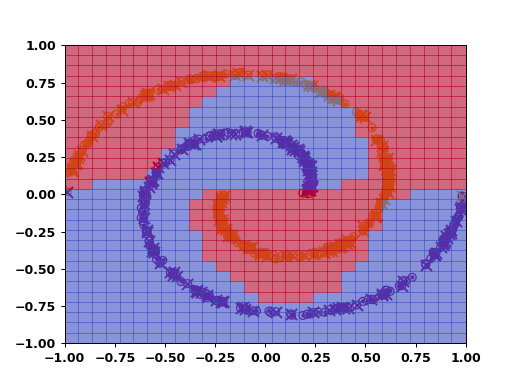

In [11]:
from sklearn.linear_model import *
import sklearn 

output_train_store = np.array(output_train_store)
output_test_store = np.array(output_test_store)

classification_model = LogisticRegression(C=1e6)
classification_model.fit(output_train_store, train_labels)

train_predictions = classification_model.predict(output_train_store)
test_predictions = classification_model.predict(output_test_store)


accuracy_train = sklearn.metrics.accuracy_score(train_labels, train_predictions)
accuracy_test = sklearn.metrics.accuracy_score(test_labels, test_predictions)

print('Train - ',accuracy_train, 'Test - ',accuracy_test)
def get_individual_color(label):
    if label==0:
        return 'purple'
    else:
        return 'orange'

subplots()

try:
    preds = classification_model.predict(output_gen_store)
    xx,yy=np.meshgrid(x,y)
    pcolormesh(xx,yy,np.transpose(preds.reshape(len(x),len(y))),cmap='PuOr_r',alpha=0.6)

except: 
    pass

for i in range(0, len(x_train)):
    scatter(x_train[i][0],x_train[i][1],marker = 'o', s=40, lw = 1, edgecolor=get_individual_color(train_labels[i]), facecolors='none')
    scatter(x_train[i][0],x_train[i][1],marker = '.', s=20, edgecolor=get_individual_color(train_predictions[i]), facecolors=get_individual_color(train_predictions[i]))
    
for i in range(0, len(x_test)):
    scatter(x_test[i][0],x_test[i][1],marker = 'o', s=40, lw = 1, edgecolor=get_individual_color(test_labels[i]), facecolors='none')
    scatter(x_test[i][0],x_test[i][1],marker = 'x', s=80, edgecolor=get_individual_color(test_predictions[i]), facecolors=get_individual_color(test_predictions[i])) 





In [12]:
x=np.linspace(-1,1,30)
y=np.linspace(-1,1,30)
x_gen = []
for i in range(0,len(x)):
    for j in range(0,len(y)):
        x_gen.append(np.array([x[i],y[j]]))
x_gen=np.array(x_gen)

output_gen_store=[]
for i in range(0,len(x_gen)):
    print(str(i),' of ', str(len(x_gen)),end='\r')
    features = x_gen[i]
    initial_condition = encoding(n_oscillators,features, A)
    T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
    output_gen_store.append(positions[-1,:])
    
preds = classification_model.predict(output_gen_store)
xx,yy=np.meshgrid(x,y)
pcolormesh(xx,yy,np.transpose(preds.reshape(len(x),len(y))),cmap='coolwarm',alpha=0.6)

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

<IPython.core.display.Javascript object>


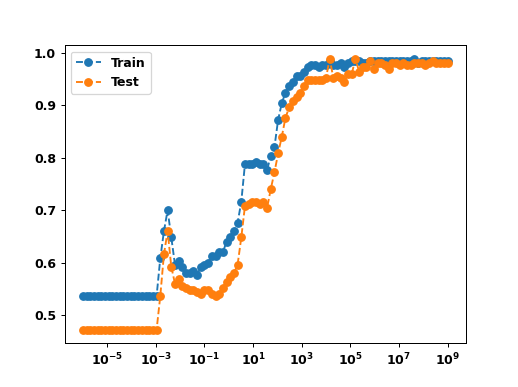

In [13]:
Cs = np.logspace(-6,9,100)

accuracies_train = []
accuracies_test = []
for i in range(0,len(Cs)):
    classification_model = LogisticRegression(C=Cs[i])
    classification_model.fit(output_train_store, train_labels)

    train_predictions = classification_model.predict(output_train_store)
    test_predictions = classification_model.predict(output_test_store)

    accuracy_train = sklearn.metrics.accuracy_score(train_labels, train_predictions)
    accuracy_test = sklearn.metrics.accuracy_score(test_labels, test_predictions)

    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)

subplots()
plot(Cs, accuracies_train,ls='--',marker='o',label='Train')
plot(Cs, accuracies_test,ls='--',marker='o',label='Test')
legend()
xscale('log')

# Chaoticity Metrics

<IPython.core.display.Javascript object>


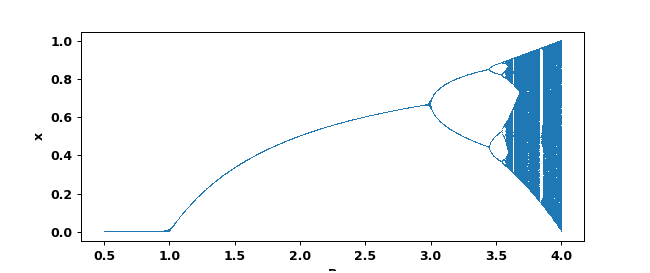

In [19]:
import numpy as np 
import matplotlib.pyplot as plt

subplots()
def bifunc():
    R_val = []
    X_val = []
    R = np.linspace(0.5, 4, 1000)
    for r in R:
        x = 0.5
        for iterations in range(1001):
            x = x*r*(1-x)
            if iterations > 100:
                R_val.append(r)
                X_val.append(x)
    plt.plot(R_val, X_val, ls='', marker=',')
    xlabel('R')
    ylabel('x')


bifunc()

In [76]:
from scipy.signal import *
from tqdm.notebook import *

n_oscillators = 3

A = 1.8
v=0.1
features = [1]
tstop = 1000
xmaxs = []
def get_max(x, t, dropout):
    peak_index, properties = find_peaks(sig,prominence=0.01)
    filtered_peak_index = []
    for i in range(0,len(peak_index)):
        if t[peak_index[i]]>dropout:
            filtered_peak_index.append(peak_index)
    filtered_peak_index = np.array(filtered_peak_index)
    return x[filtered_peak_index], t[filtered_peak_index]

As = np.linspace(0.1, 2, 20)
Plot_figs=False
vs = np.linspace(0.1, 5,20)

bar = tqdm(total = len(As))

if Plot_figs==True:
    fig, ax = subplots(1*len(vs),2,figsize=[10,4*len(vs)])

for m in range(0,len(vs)):
    A = 2.
    v = vs[m]
    
    bar.update(1)
    initial_condition = encoding(n_oscillators,features, A, delta)
    T,Y,positions=todachain(v,n_oscillators,tinit,tstop,dt,initial_condition)
    
    index_oscillator = 0
    dropout_time = 100
    ts = T
    sig = positions[:,2*index_oscillator]
    x_max, t_max = get_max(sig, ts, dropout_time)
    xmaxs.append(x_max)
    
    if Plot_figs==True:

        for j in range(0,n_oscillators):
            ax[m,0].plot(T,positions[:,j]+(j*delta+delta/2),'--',color='k')
        ax[m,0].set_xlabel('Time (arb.un.)')
        ax[m,0].set_ylabel('x (arb.un)')
        ax[m,1].plot(Y[:,0],Y[:,1])
        ax[m,0].plot(t_max,x_max+(index_oscillator*delta+delta/2),'o',color='orange', ls='')



    
    

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


IndexError: arrays used as indices must be of integer (or boolean) type

<IPython.core.display.Javascript object>


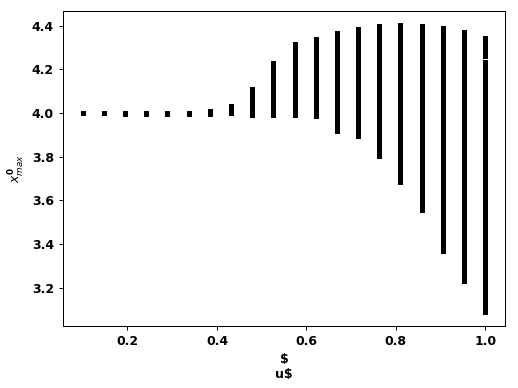

In [74]:
subplots()
for i in range(0,len(vs)):
    plot(np.ones(len(xmaxs[i]))*vs[i], xmaxs[i],'.',ls='',color='k')
xlabel('$\nu$')
ylabel('$x^'+str(index_oscillator)+'_{max}$')
tight_layout()

<IPython.core.display.Javascript object>


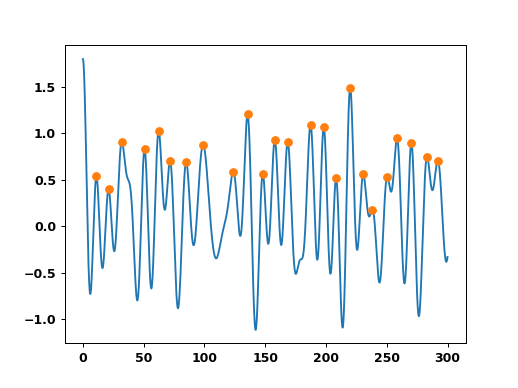

In [38]:
subplots()
plot(T, positions[:,0], ls='-')

from scipy.signal import *
ts = T
sig = positions[:,0]

peak_index, properties = find_peaks(sig,prominence=0.01)
plot(ts[peak_index],sig[peak_index],'o',ls='')